# <center> **Dense Optical Flow** </center>

Dense optical flow attempts to compute the optical flow vector for every pixel of each frame. While such computation may be slower, it gives a more accurate result and a denser result suitable for applications such as learning structure from motion and video segmentation.

In [9]:
# Libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
import time

## **Image Gradient**

* Image is a matrix of pixel values representing various intensity level values.
* A pixel is the building block of an image.
* The gradient can be defined as the change in the direction of the intensity level of an image.

In [10]:
def image_gradient(img1, img2):
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = convolve(img1,x_kernel)
    fy = convolve(img1, y_kernel)
    ft = convolve(img1, -t_kernel) + convolve(img2, t_kernel)

    return [fx, fy, ft]

# **Horn-Schunck method**

### **Horn-Schunck Function**

In [11]:
# Function: Horn-Schunck Optical Flow method
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# corner_list: List corners
# window_size: Window size (tuple)
# Return: vx, vy, corner_list
def Horn_Schunck_Optical_Flow(beforeImg, afterImg, alpha=1, delta=0.01, num_iter=100, avg_kernel=np.zeros((3, 3))):
    shape = np.shape(beforeImg)

    # set up initial values
    u = np.zeros(shape)
    v = np.zeros(shape)

    fx = np.diff(np.pad(afterImg, ((0, 0), (0, 1)), 'edge'), axis=1).reshape(shape) / 2.0
    fy = np.diff(np.pad(afterImg, ((0, 1), (0, 0)), 'edge'), axis=0).reshape(shape) / 2.0
    ft = afterImg - beforeImg

    iter_counter = 0

    while True:
        iter_counter += 1
        u_avg = convolve(u, avg_kernel)
        v_avg = convolve(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.sqrt(np.sum((u - prev) ** 2))

        # Converges check
        if  diff <= delta or iter_counter >= num_iter:
            break
    
    return u, v

## **Plot image - Plot video**

In [12]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_image_optical_flow(img, vx, vy, stride=10):
    height, width = img.shape[:2]
    x, y = np.meshgrid(np.arange(0, width, stride), np.arange(0, height, stride))
    x = x.flatten()
    y = y.flatten()
    flow_vx = vx[::stride, ::stride].flatten()
    flow_vy = vy[::stride, ::stride].flatten()

    plt.imshow(img)
    plt.quiver(x, y, flow_vx, flow_vy, color='y', angles='xy')
    plt.show()

In [13]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_video_optical_flow(img, vx, vy, stride=10):
    height, width = img.shape[:2]
    
    for i in range(0, height, stride):
        for j in range(0, width, stride):
            cv2.arrowedLine(img, (j, i), (int(j + vx[i][j]), int(i + vy[i][j])), color=(0, 255, 255),
                            thickness=1)
    cv2.imshow("frame", img)

def plot_video_hsv(img, vx, vy):
    hsv = np.zeros_like(img)
    mag, ang = cv2.cartToPolar(vx, vy)

    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imshow('frame', bgr)

def draw_flow(img, fx, fy, stride=10): # xem xet chuyen dong dang thay doi trong hinh anh
    h, w = img.shape[:2] # trich xuat chieu cao h = img.shape[0] va rong cua anh w = img.shape[1]
    y, x = np.mgrid[stride/2:h:stride, stride/2:w:stride].reshape(2,-1).astype(int)

    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2) # 2 cai anh ghep theo chieu doc
    lines = np.int32(lines + 0.5)

    cv2.polylines(img, lines, 0, (0, 255, 0)) # noi cac diem khong thang hang

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img, (x1, y1), 1, (0, 255, 0), -1)

    cv2.imshow("frame", img)

def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi # góc có dấu tính bằng radian giữa tia kết thúc tại điểm gốc và đi qua điểm (1,0), 
                                        # và tia kết thúc tại điểm gốc và đi qua điểm ( x2 , x1 )
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8) # tao 1 ma tran bang 0
    hsv[...,0] = ang*(180/(np.pi/2))
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

### **Test Horn-Schunck function with two frames**

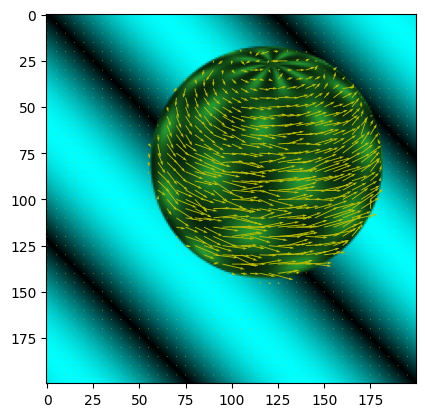

In [14]:
fig_size = (10, 10)
avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                       [1 / 6 , 0    , 1 / 6 ],
                       [1 / 12, 1 / 6, 1 / 12]], float)

image1 = cv2.imread(r"image/sphere1.bmp")
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY).astype(float)

image2 = cv2.imread(r"image/sphere2.bmp")
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY).astype(float)

vx, vy = Horn_Schunck_Optical_Flow(beforeImg   = gray_image1, 
                                   afterImg    = gray_image2,
                                   alpha       = 1          , 
                                   delta       = 0.1        ,
                                   num_iter    = 100        ,
                                   avg_kernel  = avg_kernel  )

plot_image_optical_flow(img    = image2, 
                        vx     = vx    , 
                        vy     = vy    , 
                        stride = 5      )

### **Test Horn-Schunck function with video**

**Plot vector**

In [15]:
resize_ratio = 2
video_path = "video/test.mp4"

# Read video
cap = cv2.VideoCapture(video_path)

# Take the first frame of the video
# ret: boolean return value, used to check whether the reading was successful
# first_frame: the first frame in the entire video sequence
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                       [1 / 6 , 0    , 1 / 6 ],
                       [1 / 12, 1 / 6, 1 / 12]], float)

while(True):
    ret, frame = cap.read()
    # if not ret:
    #     break
    start = time.time()
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical flow
    vx, vy = Horn_Schunck_Optical_Flow(beforeImg   = old_gray.astype(float)  , 
                                       afterImg    = frame_gray.astype(float),
                                       alpha       = 1                       , 
                                       delta       = 0.1                     ,
                                       num_iter    = 50                      ,
                                       avg_kernel  = avg_kernel               )

    end = time.time()
    fps = 1. / (end - start)

    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame, 
                str(round(fps, 2)) + " fps", 
                (0, shape[1]), 
                font, 1, 
                (100, 255, 0), 
                2, 
                cv2.LINE_4)

    # Plot vector
    plot_video_optical_flow(frame, vx, vy, stride=5)

    if cv2.waitKey(30) & 0xff == 27: # Escape
        break

    # Now update the previous frame
    old_gray = frame_gray.copy()

cv2.destroyAllWindows()
cap.release()

**Plot HSV**

In [16]:
# Read video
cap = cv2.VideoCapture(video_path)

# Take the first frame of the video
# ret: boolean return value, used to check whether the reading was successful
# first_frame: the first frame in the entire video sequence
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                       [1 / 6 , 0    , 1 / 6 ],
                       [1 / 12, 1 / 6, 1 / 12]], float)

while(True):
    ret, frame = cap.read()
    # if not ret:
    #     break
    start = time.time()
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical flow
    vx, vy = Horn_Schunck_Optical_Flow(beforeImg   = old_gray.astype(float)  , 
                                       afterImg    = frame_gray.astype(float),
                                       alpha       = 1                       , 
                                       delta       = 0.1                     ,
                                       num_iter    = 50                      ,
                                       avg_kernel  = avg_kernel               )

    end = time.time()
    fps = 1. / (end - start)

    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame, 
                str(round(fps, 2)) + " fps", 
                (0, shape[1]), 
                font, 1, 
                (100, 255, 0), 
                2, 
                cv2.LINE_4)

    # Plot vector
    plot_video_hsv(frame, vx, vy)

    if cv2.waitKey(30) & 0xff == 27: # Escape
        break

    # Now update the previous frame
    old_gray = frame_gray.copy()

cv2.destroyAllWindows()
cap.release()

# **Compare to OpenCV**

In [ ]:
# Read video
cap = cv2.VideoCapture(video_path)

# Take the first frame of the video
# ret: boolean return value, used to check whether the reading was successful
# first_frame: the first frame in the entire video sequence
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

while(True):
    ret, frame = cap.read()
    # if not ret:
    #     break
    start = time.time()
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical flow
    vx, vy = Horn_Schunck_Optical_Flow(beforeImg   = old_gray.astype(float)  , 
                                       afterImg    = frame_gray.astype(float),
                                       alpha       = 1                       , 
                                       delta       = 0.1                     ,
                                       num_iter    = 50                      ,
                                       avg_kernel  = avg_kernel               )

    end = time.time()
    fps = 1. / (end - start)

    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame, 
                str(round(fps, 2)) + " fps", 
                (0, shape[1]), 
                font, 1, 
                (100, 255, 0), 
                2, 
                cv2.LINE_4)

    # Plot vector
    plot_video_optical_flow(frame, vx, vy, stride=5)

    if cv2.waitKey(30) & 0xff == 27: # Escape
        break

    # Now update the previous frame
    old_gray = frame_gray.copy()

cv2.destroyAllWindows()
cap.release()